# Imports

In [1]:
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
import anndata2ri
import logging
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

/tmp/ipykernel_8624/2174054843.py:8: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [3]:
%%R
library(tidyverse)
library(dyno)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Loading required package: dynfeature
Loading required package: dynguidelines
Loading required package: dynmethods
Loading required package: dynplot
Loading required package: dynwrap
In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/lib/R/site-library’ contains no packages


# Loading Data

In [4]:
%%R
data <- readRDS("multifurcating_1.rds")

In [5]:
%%R
str(data)

List of 17
 $ id                   : chr "synthetic/splatter/multifurcating_1"
 $ cell_ids             : chr [1:920] "Cell1" "Cell2" "Cell3" "Cell4" ...
 $ cell_info            : NULL
 $ counts               : num [1:920, 1:1254] 48 0 0 18 31 38 11 31 19 17 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:920] "Cell1" "Cell2" "Cell3" "Cell4" ...
  .. ..$ : chr [1:1254] "Gene4247" "Gene4771" "Gene2697" "Gene3227" ...
 $ expression           : num [1:920, 1:1254] 5.25 0 0 4.26 4.36 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:920] "Cell1" "Cell2" "Cell3" "Cell4" ...
  .. ..$ : chr [1:1254] "Gene4247" "Gene4771" "Gene2697" "Gene3227" ...
 $ feature_info         : tibble [1,254 × 1] (S3: tbl_df/tbl/data.frame)
  ..$ feature_id: chr [1:1254] "Gene4247" "Gene4771" "Gene2697" "Gene3227" ...
 $ milestone_ids        : chr [1:9] "M1" "M3" "M6" "M8" ...
 $ milestone_network    : tibble [8 × 4] (S3: tbl_df/tbl/data.frame)
  ..$ from    : chr [1:8] "M1" "M3" "M6" "M3" ...
  ..

In [6]:
%%R
counts <- data$counts
expression <- data$expression

In [7]:
%%R
dataset <- wrap_expression(
  expression = expression,
  counts = counts
)

In [8]:
%%R --o grouping
grouping <- data$grouping

In [9]:
%%R
dataset <- add_prior_information(
    dataset,
    start_id = data$prior_information$start_id,
    end_id = data$prior_information$end_id,
    groups_id = data$prior_information$groups_id,
    end_n = data$prior_information$end_n,
)
dataset <- add_grouping(
    dataset,
    data$grouping
)

In [10]:
%%R
umap_dimred <- dyndimred::dimred_umap(dataset$expression)

Loading required namespace: uwot


In [11]:
%%R
pca_dimred <- dyndimred::dimred_pca(dataset$expression)

In [12]:
%%R
head(pca_dimred)

         comp_1    comp_2
Cell1 -6.211451  2.098430
Cell2  8.758015  4.593695
Cell3  9.090242  3.608350
Cell4  2.619722 -6.670609
Cell5 -7.073373  3.728015
Cell6 -7.627710  4.641883


In [13]:
%%R
head(expression[,1:6])

      Gene4247 Gene4771 Gene2697 Gene3227 Gene2112 Gene4564
Cell1 5.249972 4.449087 3.738908 0.825343 6.652233 2.678904
Cell2 0.000000 4.900236 3.483696 3.369842 5.956972 3.246227
Cell3 0.000000 5.048295 4.261829 1.049384 6.768637 5.048295
Cell4 4.256267 0.000000 2.328973 5.052929 6.434964 4.962714
Cell5 4.358955 2.986671 3.469210 4.486004 3.199402 3.830173
Cell6 5.447801 4.683146 3.318788 4.244621 5.891387 4.156577


In [14]:
%%R

kmeans_clusters <- kmeans(pca_dimred, centers=3, nstart=25)

pca_dimred_df <- as.data.frame(pca_dimred)
pca_dimred_df$cluster <- as.factor(kmeans_clusters$cluster)
# ggplot(pca_dimred_df, aes(x=comp_1, y=comp_2, color=cluster)) +
#   geom_point() +
#   labs(title="K-means Clustering on PCA-reduced Data", x="PCA 1", y="PCA 2")

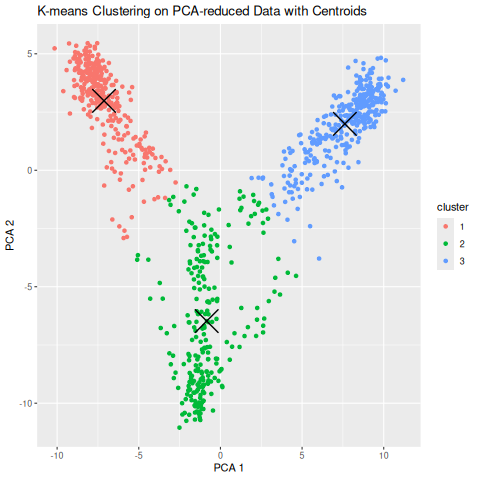

In [15]:
%%R

# Extract centroids
centroids <- as.data.frame(kmeans_clusters$centers)
colnames(centroids) <- colnames(pca_dimred_df)[1:2]

# Plot clusters with centroids
ggplot(pca_dimred_df, aes(x=comp_1, y=comp_2, color=cluster)) +
    geom_point() +
    geom_point(data=centroids, aes(x=comp_1, y=comp_2), color='black', size=10, shape=4, stroke=1) +
    labs(title="K-means Clustering on PCA-reduced Data with Centroids", x="PCA 1", y="PCA 2")

In [16]:
%%R
centroids

      comp_1    comp_2
1 -7.1289555  2.981934
2 -0.8406568 -6.473822
3  7.6184340  1.993359


# DPT Model

In [17]:
%%R
dpt_model <- infer_trajectory(dataset, ti_dpt(), give_priors = c("start_id"))

Loading required namespace: RColorBrewer


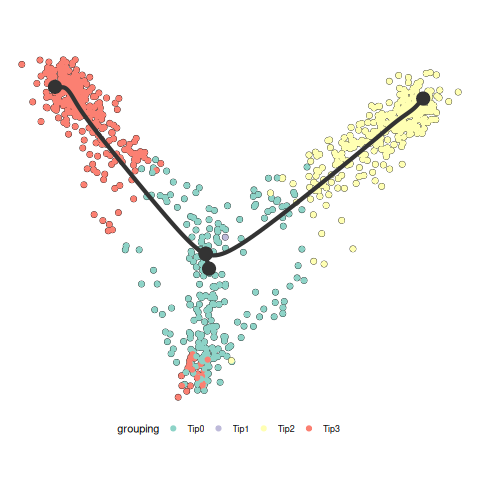

In [18]:
%%R
plot_dimred(dpt_model, color_cells=c("grouping"), dimred=pca_dimred)

In [19]:
%%R
names(dpt_model)

 [1] "id"                          "cell_ids"                   
 [3] "cell_info"                   "group_ids"                  
 [5] "grouping"                    "milestone_ids"              
 [7] "milestone_network"           "divergence_regions"         
 [9] "milestone_percentages"       "progressions"               
[11] "trajectory_type"             "directed"                   
[13] "dimred"                      "dimred_projected"           
[15] "dimred_milestones"           "dimred_segment_progressions"
[17] "dimred_segment_points"      


In [20]:
%%R
dpt_model$dimred_segment_points

                       comp_1       comp_2        comp_3        comp_4
MILESTONE_WTip0 -0.0059106238 -0.029500246 -1.524649e-03 -9.915237e-04
W2              -0.0057336543 -0.030788372 -1.552581e-03 -1.025326e-03
W3              -0.0055697715 -0.031876538 -1.579463e-03 -1.046649e-03
W4              -0.0054211246 -0.032797410 -1.604059e-03 -1.057575e-03
W5              -0.0052880297 -0.033578214 -1.625896e-03 -1.059913e-03
W6              -0.0051697222 -0.034241367 -1.645000e-03 -1.055140e-03
MILESTONE_WTip1 -0.0050747457 -0.034752951 -1.660133e-03 -1.045696e-03
MILESTONE_WTip0 -0.0059106238 -0.029500246 -1.524649e-03 -9.915237e-04
W9              -0.0048704767 -0.029954296 -1.601899e-03 -9.452294e-04
W10             -0.0037717232 -0.030069935 -1.680044e-03 -8.761798e-04
W11             -0.0025452048 -0.029810905 -1.760224e-03 -7.794648e-04
W12             -0.0011061668 -0.029112461 -1.844260e-03 -6.498533e-04
W13              0.0006483859 -0.027879198 -1.934196e-03 -4.822726e-04
W14   

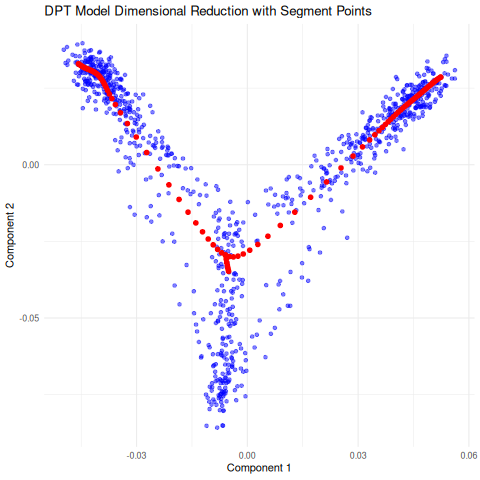

In [21]:
%%R
# Extract the segment points and the dimensional reduction data
segment_points <- dpt_model$dimred_segment_points
dimred_data <- dpt_model$dimred

# Convert to data frames for ggplot
segment_points_df <- as.data.frame(segment_points)
dimred_data_df <- as.data.frame(dimred_data)

# Plot the dimensional reduction data with segment points
ggplot() +
    geom_point(data = dimred_data_df, aes(x = comp_1, y = comp_2), color = "blue", alpha = 0.5) +
    geom_point(data = segment_points_df, aes(x = comp_1, y = comp_2), color = "red", size = 2) +
    labs(title = "DPT Model Dimensional Reduction with Segment Points", x = "Component 1", y = "Component 2") +
    theme_minimal()

In [44]:
%%R
dpt_model$dimred_milestones

           comp_1      comp_2       comp_3        comp_4      comp_5
Tip0 -0.005910624 -0.02950025 -0.001524649 -0.0009915237  0.01396034
Tip1 -0.005074746 -0.03475295 -0.001660133 -0.0010456958  0.01048679
Tip2  0.052353267  0.02856832  0.006483178 -0.0115860080 -0.02923295
Tip3 -0.045730523  0.03291757  0.012215348  0.0071560401 -0.04381922
            comp_6        comp_7        comp_8       comp_9      comp_10
Tip0  0.0015414481  0.0017020372  0.0015320425  0.004161653 -0.001672827
Tip1  0.0002894949  0.0006317647 -0.0001695202  0.006274244 -0.003324102
Tip2  0.0374998059 -0.0084717176 -0.0392437030  0.030988223  0.021084448
Tip3 -0.0328162628  0.0045980665 -0.0359492771 -0.005263981 -0.010054371
          comp_11      comp_12      comp_13       comp_14       comp_15
Tip0 -0.004377019  0.002933404 -0.002327539 -0.0009950044 -0.0031084025
Tip1 -0.005245106  0.004127853 -0.003314222 -0.0018505694 -0.0040520477
Tip2 -0.014387050 -0.006649563  0.008454775 -0.0061263895 -0.0005532088
Ti

In [23]:
miles=1
cels=1

In [24]:
%%R -o miles -o cels
miles <- as.data.frame(dpt_model$dimred_milestones)
cels <- as.data.frame(dpt_model$dimred)

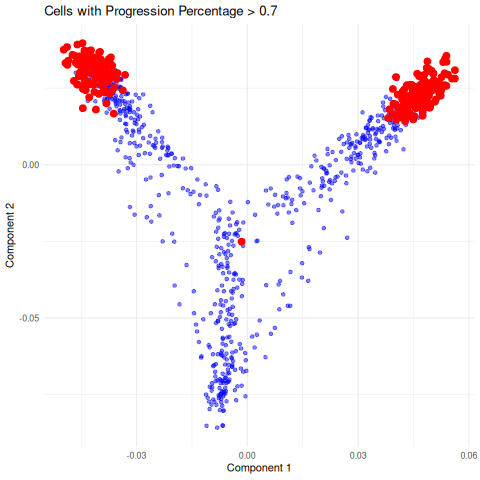

In [25]:
%%R
# Filter cells with progression percentage more than 0.7
filtered_cells <- dpt_model$progressions %>%
    filter(percentage > 0.5)

# Merge filtered cells with the dimensional reduction data
filtered_cells_merged <- merge(filtered_cells, cels, by.x = "cell_id", by.y = "row.names")

# Plot the filtered cells
ggplot() +
    geom_point(data = cels, aes(x = comp_1, y = comp_2), alpha = 0.5, color = "blue") +
    geom_point(data = filtered_cells_merged, aes(x = comp_1, y = comp_2), color = "red", size = 3) +
    labs(title = "Cells with Progression Percentage > 0.7", x = "Component 1", y = "Component 2") +
    theme_minimal()

{'Tip0': np.float64(1.1151203300816336e-07), 'Tip1': np.float64(1.5367958103146502e-07), 'Tip2': np.float64(6.650961305105065e-08), 'Tip3': np.float64(1.0470608586309214e-07)}
{'Tip0': 'Cell516', 'Tip1': 'Cell489', 'Tip2': 'Cell235', 'Tip3': 'Cell14'}


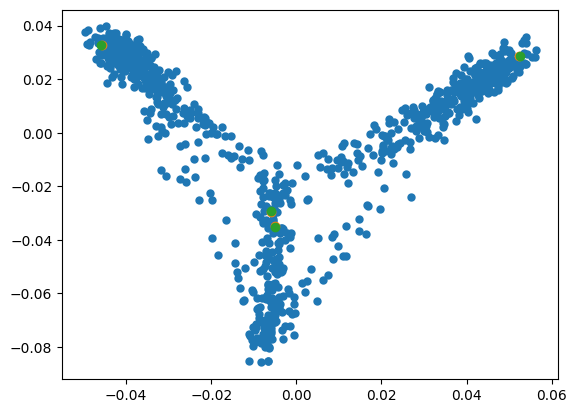

In [26]:
import matplotlib.pyplot as plt

close = {}
dist = {}
for m in miles.index:
    close[m]=''
    dist[m]=1000
    for c in cels.index:
        d = (cels.loc[c]['comp_1'] - miles.loc[m]['comp_1'])**2 + (cels.loc[c]['comp_2'] - miles.loc[m]['comp_2'])**2
        if d<dist[m]:
            dist[m]=d
            close[m]=c
print(dist)
print(close)
plt.scatter(cels['comp_1'],cels['comp_2'],linewidths=0.01)
plt.scatter(miles['comp_1'],miles['comp_2'])
lx,ly=[],[]
for c in close.values():
    lx.append(cels.loc[c]['comp_1'])
    ly.append(cels.loc[c]['comp_2'])
plt.scatter(lx,ly)
plt.show()

In [27]:
import pandas as pd
close_df = pd.DataFrame(list(close.values()),index=list(close.keys()),columns=['closest_cell',])
close_df

,closest_cell
Tip0,Cell516
Tip1,Cell489
Tip2,Cell235
Tip3,Cell14


In [28]:
%%R -i close_df
closest_cells <- close_df
closest_cells

     closest_cell
Tip0      Cell516
Tip1      Cell489
Tip2      Cell235
Tip3       Cell14


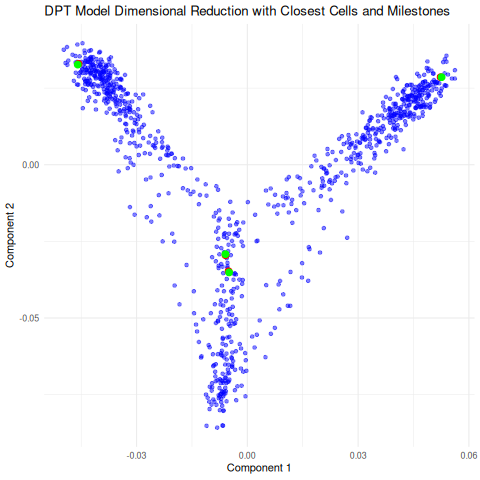

In [29]:
%%R

library(ggplot2)

# Convert closest_cells to a data frame
closest_cells_df <- as.data.frame(closest_cells)

# Merge closest cells with the dimred data
closest_cells_merged <- merge(closest_cells_df, cels, by.x = "closest_cell", by.y = "row.names")

# Plot the cells, milestones, and closest cells
ggplot() +
    geom_point(data = cels, aes(x = comp_1, y = comp_2), alpha = 0.5, color = "blue") +
    geom_point(data = miles, aes(x = comp_1, y = comp_2), color = "red", size = 3) +
    geom_point(data = closest_cells_merged, aes(x = comp_1, y = comp_2), color = "green", size = 3, shape = 21, fill = "green") +
    labs(title = "DPT Model Dimensional Reduction with Closest Cells and Milestones", x = "Component 1", y = "Component 2") +
    theme_minimal() +
    theme(legend.position = "bottom")


In [30]:
dimred=1
centroids=1

In [31]:
%%R -o dimred -o centroids

dimred <- pca_dimred_df
centroids <- centroids

/home/satwik/dynooenv/lib/python3.12/site-packages/matplotlib/cbook.py:1709: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


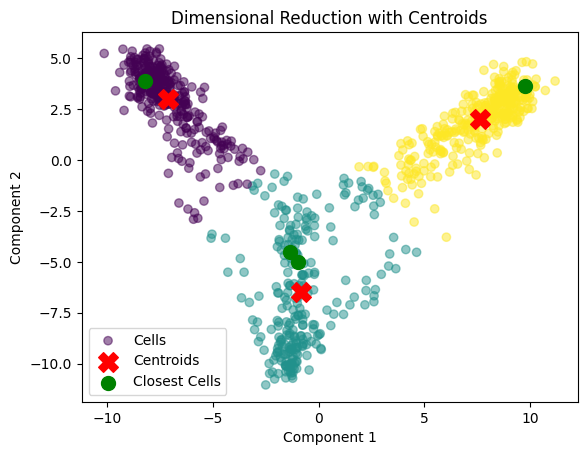

In [32]:
import matplotlib.pyplot as plt

# Plot the dimred data points
plt.scatter(dimred['comp_1'], dimred['comp_2'], c=dimred['cluster'].astype(int), cmap='viridis', alpha=0.5, label='Cells')

# Plot the centroids
plt.scatter(centroids['comp_1'], centroids['comp_2'], c='red', marker='X', s=200, label='Centroids')

lx,ly=[],[]
for c in close_df.values:
    lx.append(dimred.loc[c]['comp_1'])
    ly.append(dimred.loc[c]['comp_2'])
plt.scatter(lx,ly,label='Closest Cells', c='green', marker='o', s=100)

# Add labels and title
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Dimensional Reduction with Centroids')
plt.legend()
plt.show()

In [33]:
network=1

In [34]:
%%R -o network
network <- dpt_model$milestone_network

In [35]:
dist = pd.DataFrame(columns=[s for s in centroids.columns] + [s for s in close_df.index])
for s in centroids.columns:
    dist[s] = centroids[s]
dist

,comp_1,comp_2,Tip0,Tip1,Tip2,Tip3
1,-7.128955,2.981934,NaN,NaN,NaN,NaN
2,-0.840657,-6.473822,NaN,NaN,NaN,NaN
3,7.618434,1.993359,NaN,NaN,NaN,NaN


In [36]:
for m in close_df.index:
    close_df.loc[m,'comp_1'] = dimred.loc[close_df.loc[m,'closest_cell'],'comp_1']
    close_df.loc[m,'comp_2'] = dimred.loc[close_df.loc[m,'closest_cell'],'comp_2']
close_df

,closest_cell,comp_1,comp_2
Tip0,Cell516,-1.365398,-4.535519
Tip1,Cell489,-0.972377,-4.991280
Tip2,Cell235,9.765762,3.612076
Tip3,Cell14,-8.223505,3.870674


In [37]:
for m in close_df.index:
    for i in dist.index:
        dist.loc[i,m] = (close_df.loc[m,'comp_1'] - dist.loc[i,'comp_1'])**2 + (close_df.loc[m,'comp_2'] - dist.loc[i,'comp_2'])**2
dist

,comp_1,comp_2,Tip0,Tip1,Tip2,Tip3
1,-7.128955,2.981934,89.730685,101.475585,285.828552,1.987897
2,-0.840657,-6.473822,4.032374,2.215283,214.221456,161.515045
3,7.618434,1.993359,123.335482,122.587215,7.231261,254.491334


In [38]:
for i in dist.index:
    for m in close_df.index:
        dist.loc[i,m] = 1/dist.loc[i,m]
    s = 0
    for m in close_df.index:
        s += dist.loc[i,m]
    for m in close_df.index:
        dist.loc[i,m] /= s
dist

,comp_1,comp_2,Tip0,Tip1,Tip2,Tip3
1,-7.128955,2.981934,0.021125,0.01868,0.006632,0.953563
2,-0.840657,-6.473822,0.349157,0.635554,0.006572,0.008717
3,7.618434,1.993359,0.05116,0.051472,0.872574,0.024794


In [39]:
# adj = {}
# for m in close_df.index:
#     adj[m] = []
# for i,row in network.iterrows():
#     adj[row['from']].append(row['to'])
#     if row['directed'] == False:
#         adj[row['to']].append(row['from'])
# adj

In [40]:
# def dfs(node, target, visited):
#     if node == target:
#         return True
#     visited.add(node)
#     for neighbor in adj[node]:
#         if neighbor not in visited:
#             if dfs(neighbor, target, visited):
#                 return True
#     return False

# is_path = {}
# for m1 in close_df.index:
#     for m2 in close_df.index:
#         is_path[(m1, m2)] = dfs(m1, m2, set())

# is_path

In [41]:
network

,from,to,length,directed
1,Tip0,Tip1,0.001245,False
2,Tip0,Tip2,0.010768,False
3,Tip0,Tip3,0.009091,False


In [43]:
dist.index = ['M' + str(i) for i in range(1, len(dist) + 1)]
dist

,comp_1,comp_2,Tip0,Tip1,Tip2,Tip3
M1,-7.128955,2.981934,0.021125,0.01868,0.006632,0.953563
M2,-0.840657,-6.473822,0.349157,0.635554,0.006572,0.008717
M3,7.618434,1.993359,0.05116,0.051472,0.872574,0.024794
